# ECE232E Project 3 - Reinforcement learning and Inverse Reinforcement learning
Due on Monday, May 19, 2025 by 11:59 PM PDT

Team: Weikeng Yang, Jiacheng Wang, Chenggong Zhang

Reinforcement Learning (RL) vs Inverse Reinforcement Learning (IRL)

| Aspect | Reinforcement Learning (RL) | Inverse Reinforcement Learning (IRL) |
|--------|------------------------------|--------------------------------------|
| **Input** | Known reward function \( R(s) \), environment | Expert behavior (policy or trajectories) |
| **Output** | Optimal policy \( \pi^* \) or value function \( V(s) \) | Inferred reward function \( R(s) \) |
| **Goal** | Learn how to act optimally to maximize cumulative reward | Understand *why* an expert acts a certain way |
| **Problem Direction** | Reward → Policy | Policy → Reward |
| **Learning Paradigm** | Trial-and-error based optimization | Behavioral inference from demonstrations |
| **Assumptions** | Reward is known or designed | Expert acts optimally or near-optimally |
| **Key Algorithms** | Value Iteration, Q-learning, Policy Gradient | Max-margin IRL, Max-entropy IRL, Bayesian IRL |
| **Applications** | Game agents, robotics, control systems | Imitation learning, autonomous driving, ethics modeling |
| **Complexity** | Typically easier (well-posed) | More ill-posed, multiple possible reward functions |


> **Summary**:  
> RL teaches an agent *how to act*, while IRL helps us *understand why the expert acts that way*.  
> IRL relies on RL techniques to validate the inferred rewards and derive policies from them.

Resources:
- https://www.diva-portal.org/smash/get/diva2:1351647/FULLTEXT01.pdf

# Part 1. Reinforcement Learning (RL)

**Reinforcement Learning (RL)** is the task of learning from interaction to achieve a goal.  
- The learner and the decision maker is called the *agent*.  
- The thing it interacts with, comprising everything outside the agent, is called the *environment*.

![RL interaction diagram](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-o3tTH2Z-lyEfSThKSgVjAFvyCel5ukcxSw&s)

These interact continually: the agent selects actions and the environment responds by presenting rewards and new states.

In Part 1, we will learn the **optimal policy** of a single agent navigating in a 2-D environment using the **Value Iteration** algorithm.  
In Part 2, we will apply **Inverse Reinforcement Learning (IRL)** to recover the expert’s reward function from the observed optimal policy.

In [147]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Environment (Grid Board) Setup

- **Grid**: 10 × 10 2D square grid (100 states)
- **Actions - set($A$)**: Up, Down, Left, Right
- **Wind effect**:
  - Each action moves in intended direction with probability \( $1 - w$ \)
  - With wind probability \( $w$ \), the agent is randomly blown to a neighboring state, this probability is uniformly distributed over the 4 neighbors.

![grid](https://p.ipic.vip/n7uhpr.png)
#### Reward Function Assumption

To simplify, we assume the reward depends only on the **next state**:

$$
R^a_{ss'} = R(s')
$$

Two reward functions will be provided as 10×10 matrices (Reward 1 and Reward 2).

In [148]:
## Define the gridworld MDP class
## extended from helper code in rl_helpers.py provided in Bruinlearn
class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount, reward_type=None):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount
        self.reward_type = reward_type # 'function1' or 'function2'

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    # Todo 2.1.3: fill in the missing methods
    #
    def _state_on_edge(self, i):
        n = self.grid_size
        if i in (0, n - 1, (n - 1) * n, n * n - 1):
            return False
        return i < n or i >= n * n - n or i % n == 0 or i % n == n - 1

    def _state_on_corner(self, i):
        n = self.grid_size
        corner_points = [0, n - 1, (n - 1) * n, n * n - 1] # (0, 9, 90, 99)
        return i in corner_points

    def _moving_off_grid(self, xi, xj, yi, yj):
        n = self.grid_size
        new_x, new_y = xi + xj, yi + yj
        return new_x < 0 or new_x >= n or new_y < 0 or new_y >= n

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given action j.
        Handles corner, edge, and interior transitions with wind.

        i: current state index
        j: action index (0~3)
        k: destination state index
        """
        xi, yi = self.int_to_point(i)
        xk, yk = self.int_to_point(k)
        xj, yj = self.actions[j]

        # Case1: If k is not a neighbor (including self), transition impossible
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Case2. Intended move
        intended_x = xi + xj
        intended_y = yi + yj
        if (xk, yk) == (intended_x, intended_y):
            if 0 <= intended_x < self.grid_size and 0 <= intended_y < self.grid_size:
                return 1 - self.wind + self.wind / 4  # intended success + wind same dir
            else:
                # move would go off-grid
                return 0.0

        # Case3. Wind-only move (not intended direction)
        for a_prime, (dx, dy) in enumerate(self.actions):
            if a_prime != j and (xi + dx, yi + dy) == (xk, yk):
                if 0 <= xk < self.grid_size and 0 <= yk < self.grid_size:
                    return self.wind / 4

        # Case4. Stay in place (k == i)
        if (xk, yk) == (xi, yi):
            is_corner = self._state_on_corner(i)
            is_edge = self._state_on_edge(i)
            action_out = self._moving_off_grid(xi, xj, yi, yj)

            if is_corner:
                if action_out:
                    return 1 - self.wind + self.wind / 2
                else:
                    return self.wind / 2
            elif is_edge:
                if action_out:
                    return 1 - self.wind + self.wind / 4
                else:
                    return self.wind / 4
            else:
                return 0.0

        # Case other. All other cases (should be unreachable)
        return 0.0


    '''
    def _transition_probability(self, i, j, k):
        xi, yi = self.int_to_point(i)
        xk, yk = self.int_to_point(k)

        prob = 0.0

        for a_prime, (dx, dy) in enumerate(self.actions):
            # each direction has a probability of w/4 (wind), expected direction is (1 - w)
            wind_prob = self.wind / 4.0
            if a_prime == j:
                move_prob = 1.0 - self.wind + wind_prob # (1 - w) + w/4
            else:
                move_prob = wind_prob  # w/4

            new_x = xi + dx
            new_y = yi + dy

            # move off the grid
            if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                next_state = self.point_to_int((new_x, new_y))
            else:
                next_state = i  # moving off, stay at current state
            #
            if next_state == k:
                prob += move_prob

        return prob
    '''
    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        # Todo: Implement the reward function for two different reward functions based on the given figures
        positive_reward = 10 # Positive reward for reaching the goal
        negative_reward = -100
        if self.reward_type == "type1":
            neg_coords = [
                (2, 5), (2, 6), (3, 5), (3, 6),
                (4, 1), (4, 2), (5, 1), (5, 2),
                (8, 2), (8, 3), (9, 2), (9, 3)
            ]
            goal = (9, 9)
            if self.int_to_point(state_int) in neg_coords:
                return -10
            elif self.int_to_point(state_int) == goal:
                return 1
            else:
                return 0

        elif self.reward_type == "type2":
            neg_coords = [
                (1, 4), (1, 5), (1, 6),
                (2, 4), (2, 6),
                (3, 4), (3, 6), (3, 7), (3, 8),
                (4, 4), (4, 8),
                (5, 4), (5, 8),
                (6, 4), (6, 8),
                (7, 6), (7,7), (7, 8),
                (8, 6),
            ]
            goal = (9, 9)
            if self.int_to_point(state_int) in neg_coords:
                return negative_reward
            elif self.int_to_point(state_int) == goal:
                return positive_reward
            else:
                return 0

        else:
            raise ValueError(f"Unknown reward_type: {self.reward_type}")



In [149]:
'''
def test_transition_total_probability(gridworld):
    for i in range(gridworld.n_states):
        for j in range(gridworld.n_actions):
            total_prob = 0.0
            for k in range(gridworld.n_states):
                total_prob += gridworld._transition_probability(i, j, k)
            if not np.isclose(total_prob, 1.0):
                print(f"Error: P(sum) for state {i}, action {j} = {total_prob}")
            else:
                print(f" State {i}, Action {j}: Passed")

gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_type="type1")
test_transition_total_probability(gw)
'''

'\ndef test_transition_total_probability(gridworld):\n    for i in range(gridworld.n_states):\n        for j in range(gridworld.n_actions):\n            total_prob = 0.0\n            for k in range(gridworld.n_states):\n                total_prob += gridworld._transition_probability(i, j, k)\n            if not np.isclose(total_prob, 1.0):\n                print(f"Error: P(sum) for state {i}, action {j} = {total_prob}")\n            else:\n                print(f" State {i}, Action {j}: Passed")\n\ngw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_type="type1")\ntest_transition_total_probability(gw)\n'

### Plotting utils

In [150]:
''' from rl_helpers.ipynb
def plot_matrix(matrix, title=""):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    color_plot = ax.pcolor(matrix, cmap='coolwarm', edgecolors='k', linewidths=0.5,
                           vmin=np.min(matrix), vmax=np.max(matrix))

    for i in range(num_rows):
        for j in range(num_rows):
            val = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, '{:.0f}'.format(val), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.set_title(title)

    plt.colorbar(color_plot, ax=ax)
    ax.grid()
    plt.show()
    plt.close()
'''


' from rl_helpers.ipynb\ndef plot_matrix(matrix, title=""):\n    fig, ax = plt.subplots()\n    num_rows = len(matrix)\n    min_val, max_val = 0, num_rows\n\n    color_plot = ax.pcolor(matrix, cmap=\'coolwarm\', edgecolors=\'k\', linewidths=0.5,\n                           vmin=np.min(matrix), vmax=np.max(matrix))\n\n    for i in range(num_rows):\n        for j in range(num_rows):\n            val = matrix[i][j]\n            ax.text(j + 0.5, i + 0.5, \'{:.0f}\'.format(val), va=\'center\', ha=\'center\')\n\n    ax.set_xlim(min_val, max_val)\n    ax.set_ylim(min_val, max_val)\n    ax.invert_yaxis()\n    ax.set_xticks(np.arange(max_val))\n    ax.set_yticks(np.arange(max_val))\n    ax.xaxis.tick_top()\n    ax.set_title(title)\n\n    plt.colorbar(color_plot, ax=ax)\n    ax.grid()\n    plt.show()\n    plt.close()\n'

In [151]:
## Plotting the reward value for each state of the grid

def reward_grid_plot(gw):
    grid_size = gw.grid_size
    reward_matrix = np.zeros((grid_size, grid_size))
    for j in range(grid_size):
        for i in range(grid_size):
            reward_matrix[i][j] = gw.reward(gw.point_to_int((i,j)))
    #plot_matrix(reward_matrix)
    return reward_matrix

#reward_matrix = reward_grid_plot(gw)


## Reward Function 1

### Q1: Heat maps of Reward Function 1 and 2

For visualization purpose, generate heat maps of Reward function 1 and Reward function 2. For the heat maps, make sure you display the coloring scale.
You will have 2 plots for this question.

Resource: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html

In [152]:
## Creating the gridworld MDP with the following parameters
grid_size = 10
wind = 0.1
discount = 0.8

# Make the gridworld and associated data.
gw1 = Gridworld(grid_size, wind, discount, reward_type='type1')
gw2 = Gridworld(grid_size, wind, discount, reward_type='type2')

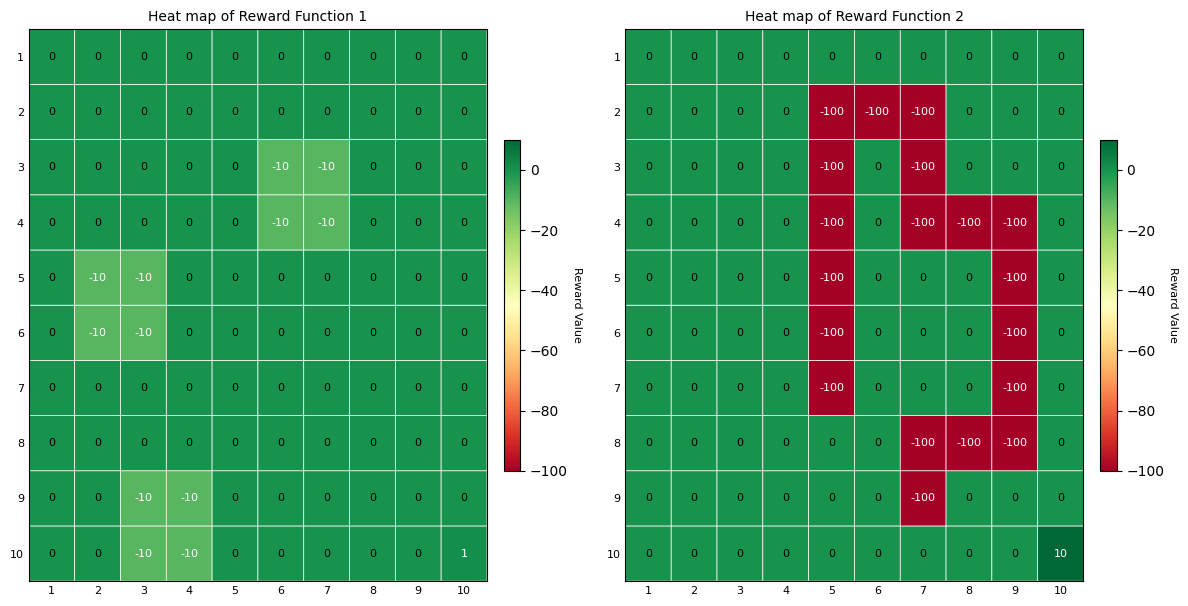

In [153]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.cm.RdYlGn # color selection

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, gw in enumerate([gw1, gw2]):
    ax = axes[i]
    reward_matrix = reward_grid_plot(gw)
    nrows, ncols = reward_matrix.shape

    c = ax.pcolor(
        np.flipud(reward_matrix),
        cmap=cmap,
        edgecolors='w',
        linewidth=0.5,
        vmin=-100,
        vmax=10
    )

    cbar = plt.colorbar(c, ax=ax, shrink=0.6, pad=0.03)
    cbar.ax.set_ylabel("Reward Value", rotation=270, labelpad=10, fontsize=8)

    for r in range(nrows):
        for c in range(ncols):
            value = reward_matrix[nrows - 1 - r, c]
            ax.text(
                c + 0.5, r + 0.5, int(value),
                ha='center', va='center',
                fontsize=8,
                color='black' if value == 0 else 'white'
            )

    ax.set_xticks(np.arange(0.5, ncols, 1))
    ax.set_yticks(np.arange(0.5, nrows, 1))
    ax.set_xticklabels(range(1, ncols+1), fontsize=8)
    ax.set_yticklabels(reversed(range(1, nrows+1)), fontsize=8)

    ax.tick_params(length=0)
    ax.grid(False)
    ax.set_title(f'Heat map of Reward Function {i+1}', fontsize=10)

plt.tight_layout(pad=0.5)
plt.show()


### Q2: Create MDP and Optimal Value Function

Create the environment of the agent using the information provided in section 2. To be specifc, create the MDP by setting up the state-space,action set, transition probabilities, discount factor, and reward function. For creating the environment, use the following set of parameters:
- Number of states = 100 (state space is a 10 by 10 square grid as displayed in figure 1)
- Number of actions = 4 (set of possible actions is displayed in figure 2)
- w = 0.1
- Discount factor = 0.8
- Reward function 1

After you have created the environment, then write an optimal state-value function that takes as input the environment of the agent and outputs the optimal value of each state in the grid. For the optimal state-value function, you have to implement the Initialization (lines 2-4) and Estimation (lines 5-13) steps of the Value Iteration algorithm. For the estimation step, use ϵ = 0.01. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this part of question, you should have 1 plot.
Let’s assume that your value iteration algorithm converges in N steps. Plot snapshots of state values in 5 different steps linearly distributed from 1 to N. Report N and your step numbers. What observations do you have from the plots?

#### Markov Decision Process (MDP)
In this project, we assume that the environment of the agent is modeled by a Markov Decision Process (MDP). In a MDP, agents occupy a state topf the environment and perform actions to change the state they are in.

The environment is modeled as a **Markov Decision Process**, defined as a tuple:

$$
(S, A, P^a_{ss'}, R^a_{ss'}, \gamma)
$$

Where:
- \( $S$ \): Set of states
- \( $A$ \): Set of actions
- \( $P^a_{ss'} = P(s_{t+1} = s' \mid s_t = s$, $a_t = a$) \): Transition probability
- \( $R^a_{ss'} = \mathbb{E}[r_{t+1} \mid s_t = s$, $a_t = a$, $s_{t+1} = s'$] \): Expected reward
- \( $\gamma \in [0, 1)$ \): Discount factor (future reward weighting)

#### Value Iteration Algorithm

We aim to compute the **optimal value function** \($V^*(s)$ \) and the **optimal policy**  $V^{\pi^*}(s)$ .

##### Value Update Equation

$$
V(s) \leftarrow \max_{a \in A} \sum_{s'} P^a_{ss'} \left[ R^a_{ss'} + \gamma V(s') \right]
$$

##### Optimal Policy Extraction

$$
\pi(s) = \arg\max_{a \in A} \sum_{s'} P^a_{ss'} \left[ R^a_{ss'} + \gamma V(s') \right]
$$

Step1. Create the MDP env

In [154]:
gw1 = Gridworld(grid_size, wind, discount, reward_type='type1')

Step2. Value iteration Implementation (Snapshot)

In [155]:
## Implementing the algorithm for computing the optimal value function for each state
## The algorithm takes as input the MDP and returns an array of optimal values,
## where i^th value in the array corresponds to the optimal value of the i^th state.
## from rl_helpers.ipynb
'''
def optimal_value(n_states, n_actions, transition_probabilities, reward,
'''
# ϵ = 0.01
def value_iteration(env, threshold=1e-2, store_history=True):
    n_states = env.n_states
    n_actions = env.n_actions
    gamma = env.discount
    reward = np.array([env.reward(s) for s in range(n_states)])

    V = np.zeros(n_states)
    history = []
    iteration = 0

    while True:
        delta = 0
        new_V = np.zeros(n_states)
        for s in range(n_states):
            action_values = []
            for a in range(n_actions):
                q_sa = sum(
                    env.transition_probability[s, a, s_next] *
                    (reward[s_next] + gamma * V[s_next])
                    for s_next in range(n_states)
                )
                action_values.append(q_sa)
            new_V[s] = max(action_values)
            delta = max(delta, abs(new_V[s] - V[s]))
        V = new_V
        iteration += 1
        if store_history:
            history.append(V.copy())
        if delta < threshold:
            break

    return V, iteration, history


V, N, history = value_iteration(gw1, threshold=1e-2, store_history=True)


In [156]:
# test
'''
reward_states = np.zeros(gw1.n_states)
for i in range(gw1.n_states):
    reward_states[i] = gw1.reward(i)

assert reward_states[99] == 1,     "Error: Reward at (9,9) should be 1"
assert reward_states[0] == 0,      "Error: Reward at (0,0) should be 0"
assert reward_states[25] == -10,   "Error: Reward at (2,5) should be -10"
assert reward_states[14] == -10,   "Error: Reward at (4,1) should be -10"
assert reward_states[15] == -10,   "Error: Reward at (5,1) should be -10"
assert reward_states[24] == -10,   "Error: Reward at (4,2) should be -10"
assert reward_states[29] == -10,   "Error: Reward at (8,2) should be -10"
assert reward_states[19] == 0,     "Error: Reward at (9,1) should be 0"
assert reward_states[49] == 0,     "Error: Reward at (9,4) should be 0"
'''

'\nreward_states = np.zeros(gw1.n_states)\nfor i in range(gw1.n_states):\n    reward_states[i] = gw1.reward(i)\n\nassert reward_states[99] == 1,     "Error: Reward at (9,9) should be 1"\nassert reward_states[0] == 0,      "Error: Reward at (0,0) should be 0"\nassert reward_states[25] == -10,   "Error: Reward at (2,5) should be -10"\nassert reward_states[14] == -10,   "Error: Reward at (4,1) should be -10"\nassert reward_states[15] == -10,   "Error: Reward at (5,1) should be -10"\nassert reward_states[24] == -10,   "Error: Reward at (4,2) should be -10"\nassert reward_states[29] == -10,   "Error: Reward at (8,2) should be -10"\nassert reward_states[19] == 0,     "Error: Reward at (9,1) should be 0"\nassert reward_states[49] == 0,     "Error: Reward at (9,4) should be 0"\n'

Step3. Visualization

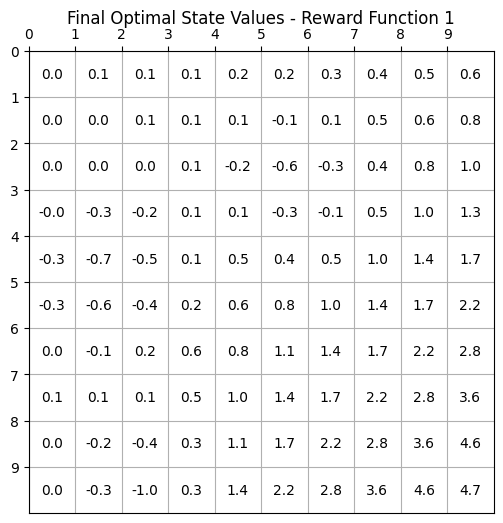

In [157]:
import matplotlib.pyplot as plt # hint In the spec
import numpy as np

def plot_value_number_grid(values, grid_size=10, title="Optimal State Values"):
    matrix = values.reshape((grid_size, grid_size)).T
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    ax.set_title(title, pad=20)
    ax.grid(True)

    for y in range(grid_size):
        for x in range(grid_size):
            val = matrix[y][x]
            ax.text(x + 0.5, y + 0.5, f"{val:.1f}", va='center', ha='center')

    plt.show()

plot_value_number_grid(V, title="Final Optimal State Values - Reward Function 1")


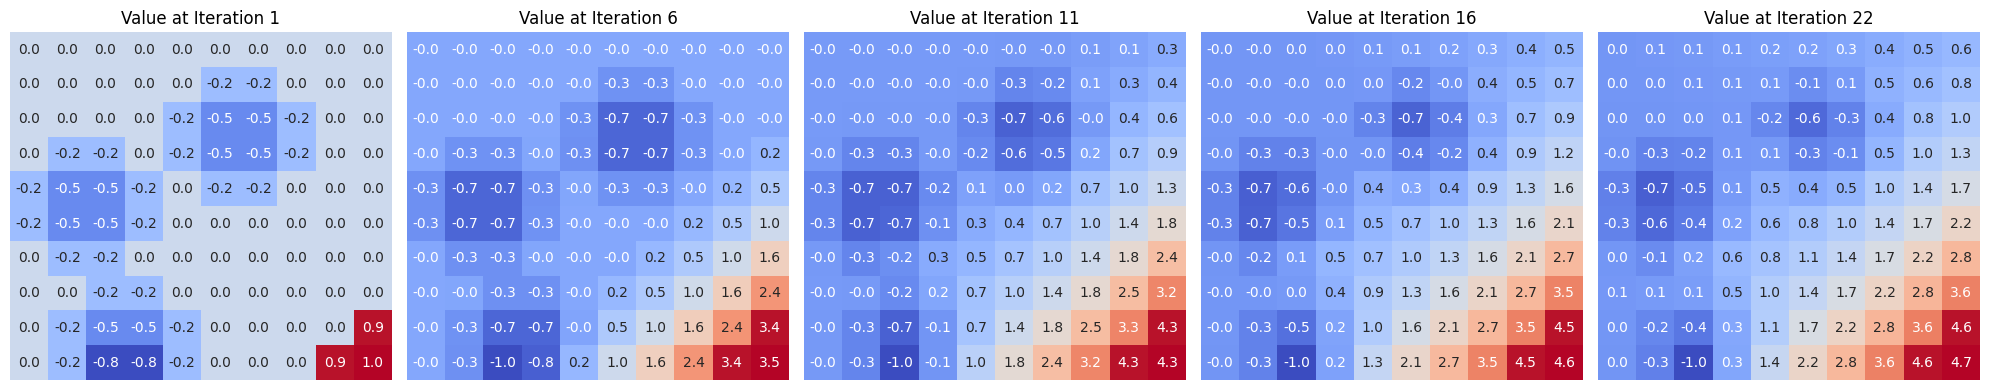

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_snapshots_in_row(history, steps, grid_size=10, title_prefix="Value at Iteration"):
    fig, axes = plt.subplots(1, len(steps), figsize=(20, 4))

    for idx, step in enumerate(steps):
        snapshot = history[step].reshape((grid_size, grid_size)).T

        ax = axes[idx]
        sns.heatmap(snapshot, annot=True, fmt=".1f", cmap="coolwarm", cbar=False, ax=ax)
        ax.set_title(f"{title_prefix} {step + 1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

steps = [int(i) for i in np.linspace(0, N - 1, num=5)]
plot_snapshots_in_row(history, steps, grid_size=grid_size)

Step4. Result and Observation

In [159]:
print(f"Converged in N = {N} iterations.")

Converged in N = 22 iterations.


N = 22

Snapshots were taken at steps: [2, 6, 12, 17, 22]

Observation:  As the value iteration progresses, we observe that the optimal state values gradually increase from the starting states toward the goal state located at the bottom-right corner. The values propagate more strongly in directions leading to the goal, forming a clear value gradient. States near negative reward regions (with value -10) show significantly lower values, indicating that the agent learns to avoid them. Overall, the value function reflects the agent’s optimal behavior of navigating toward the goal while avoiding penalty zones.

### Q3:

Generate a heat map of the optimal state values across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier (see the hint after question 1).


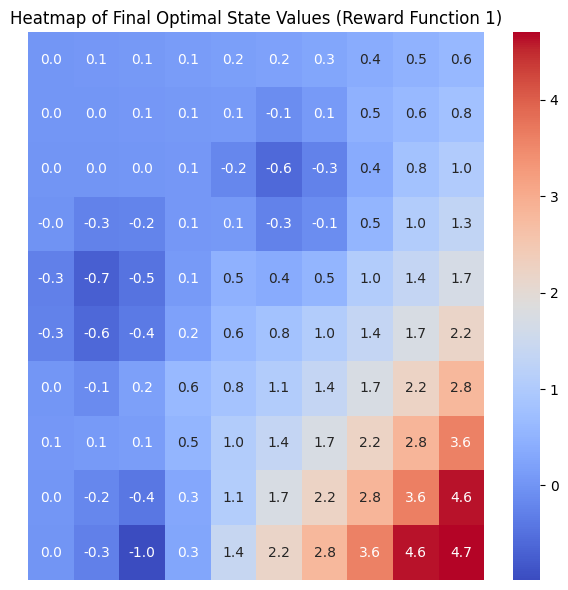

In [160]:
def plot_single_heatmap(matrix, grid_size=10, title=""):
    matrix = matrix.reshape((grid_size, grid_size)).T
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar=True,)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_single_heatmap(V, grid_size=10, title="Heatmap of Final Optimal State Values (Reward Function 1)")

### Q4:
>  Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in question 3 to explain)

Observation of Reward Function 1:

The optimal state value distribution shows a clear gradient that increases as we move toward the bottom-right corner of the grid, where the goal state is located. This state provides a positive reward (+1), and thus nearby states receive higher values due to the discounted future reward propagating backward through the grid.

On the other hand, regions near the negative reward zones (with -10 penalties) — such as the cluster in the lower-middle and mid-left parts of the grid — exhibit significantly lower state values. The agent learns to avoid these areas, resulting in “valleys” in the value function around them.

Overall, the distribution reflects an optimal policy that guides the agent from the top-left area toward the goal while navigating around high-penalty zones. The directionality and smooth transitions in the heatmap validate that value iteration has correctly identified the most rewarding paths under uncertainty (wind = 0.1).



---

### Q5: (20 points)
Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows.

In this question, you should have 1 plot

In [161]:
## Implementing the function for computing the optimal policy.
## The function takes as input the MDP and outputs a
## deterministic policy, which is an array of actions.
## The i^th entry in the array corresponds to the
## optimal action to take at the i^th state.
def find_policy(env, V=None):
    if V is None:
        V, _, _ = value_iteration(env, store_history=False)

    n_states = env.n_states
    n_actions = env.n_actions
    gamma = env.discount
    reward = np.array([env.reward(s) for s in range(n_states)])

    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q_sa = sum(
                env.transition_probability[s, a, s_next] *
                (reward[s_next] + gamma * V[s_next])
                for s_next in range(n_states)
            )
            action_values.append(q_sa)
        policy[s] = np.argmax(action_values)
    return policy

In [162]:
## Function for plotting the optimal actions at each state in the grid
## The function takes as input the matrix containing optimal actions
## and plots the actions for each state on the grid
## This function is provided from helper file from rl_helper.ipynb in Bruinlearn Modules

def plot_arrow(action_matrix, title="Optimal Policy"):

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if c == 0:
                arrow = u'↓'
            elif c == 1:
                arrow = u'→'
            elif c == 2:
                arrow = u'↑'
            else:
                arrow = u'←'

            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.set_title(title, pad=10)
    ax.grid()

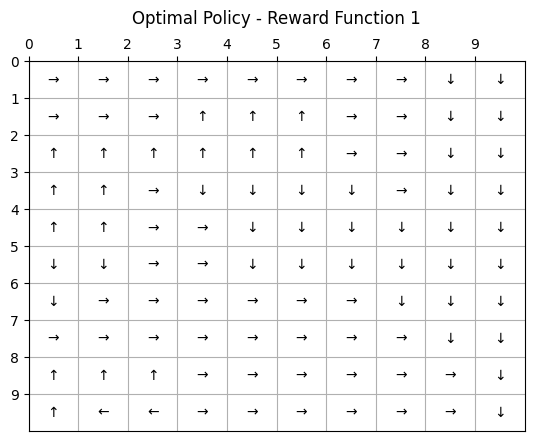

In [163]:
## Plotting the optimal actions for each state in the grid
# Finding the array of optimal policy
optimal_policy_q5 = find_policy(gw1, V)
# Generating the matrix containing the optimal actions
action_matrix_type1 = np.zeros((grid_size, grid_size))
for i in range(gw1.n_states):
    action_matrix_type1[int(i%grid_size)][int(i/grid_size)] = optimal_policy_q5[i]
# Plotting
plot_arrow(action_matrix_type1, title="Optimal Policy - Reward Function 1")


> Does the optimal policy of the agent match your intuition? Please provide a brief explanation.

Yes, the optimal policy matches intuition. The agent consistently moves toward the bottom-right goal state (9,9) while avoiding the negative reward cells, especially in the center and bottom-left of the grid. This aligns with expected behavior—maximizing rewards and minimizing penalties.


> Is it possible for the agent to compute the optimal action to take at each state by observing the optimal values of it’s neighboring states?

Yes, the agent can compute the optimal action by observing the values of its neighboring states. Since value iteration derives the policy based on the maximum expected value from neighboring transitions, choosing the neighbor with the highest value often leads to the optimal action. Minor deviations may happen due to approximations in value updates.

## Reward Function 2

### Q6:
Modify the environment of the agent by replacing Reward function 1 with Reward function 2. Use the optimal state-value function implemented in question 2 to compute the optimal value of each state in the grid. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this question, you should have 1 plot.


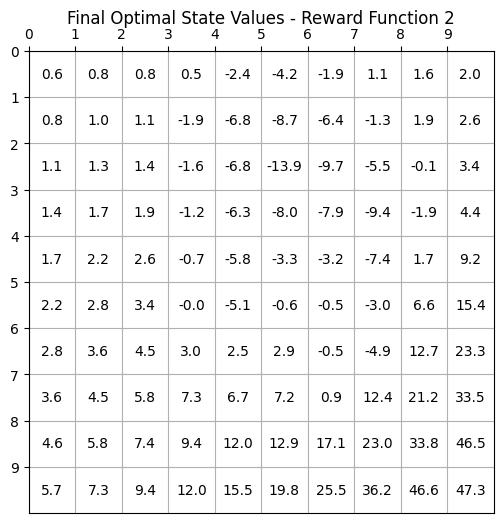

Converged in N = 32 iterations.


In [164]:
gw2 = Gridworld(grid_size, wind, discount, reward_type='type2')
V_2, N_2, history_2 = value_iteration(gw2, threshold=1e-2, store_history=True)
plot_value_number_grid(V_2, title="Final Optimal State Values - Reward Function 2")
print(f"Converged in N = {N_2} iterations.")

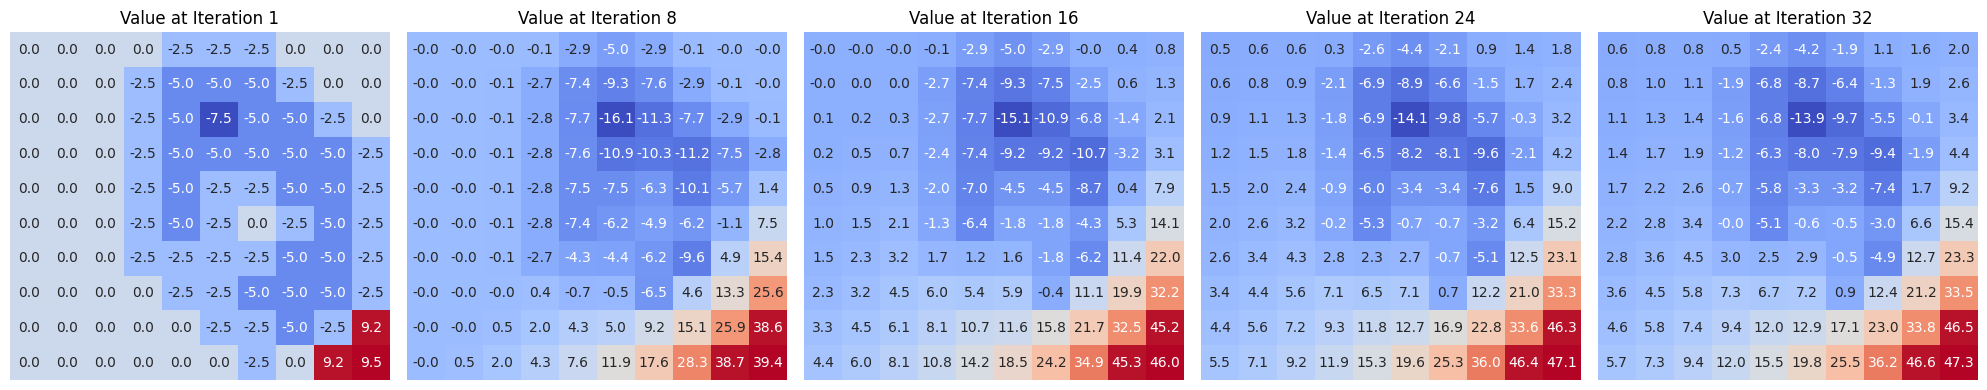

In [165]:
steps_2 = [int(i) for i in np.linspace(0, N_2 - 1, num=5)]
plot_snapshots_in_row(history_2, steps_2, grid_size=10)

### Q7:
Generate a heat map of the optimal state values (found in question 6) across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier. Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in this question to explain)

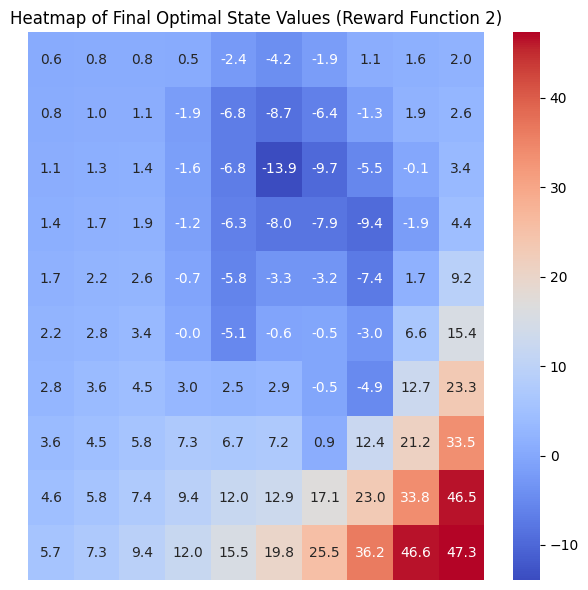

In [166]:
plot_single_heatmap(V_2, grid_size=10, title="Heatmap of Final Optimal State Values (Reward Function 2)")

Observation for Reward Function 2:

The optimal state values under Reward Function 2 show a clear gradient increasing toward the bottom-right corner, where the goal is located. The top-middle region of the grid contains strongly negative values, especially near the center, due to the large cluster of high-penalty (-100) states. It aligns with the Figure 7, the reward state of reward function 2.

This creates a “valley” of low values in the middle, effectively forming a wall that the agent learns to avoid. As a result, the optimal path avoids the central region and instead moves around the obstacle, either from the far left or the far right, toward the goal.

The value propagation from the goal spreads out more smoothly once it bypasses the negative zones, and the values increase significantly as we approach the goal, reaching values around 46–47 near (9,9). This demonstrates the agent’s long-term discounted rewards accumulated over safe paths avoiding penalties.

### Q8:
Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space.
For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. In this question, you should have 1 plot.



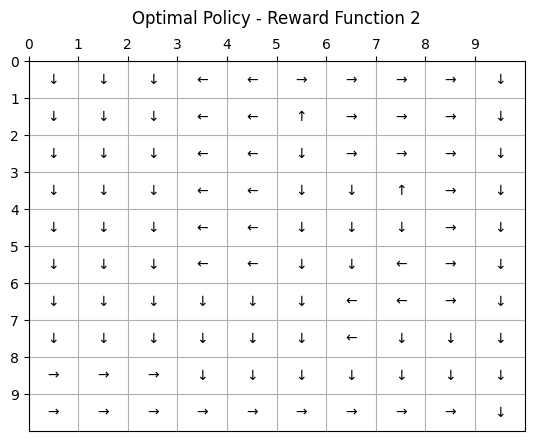

In [167]:
## Plotting the optimal actions for each state in the grid
# Finding the array of optimal policy
optimal_policy_q8 = find_policy(gw2, V_2)
grid_size = gw2.grid_size
# Generating the matrix containing the optimal actions
action_matrix_type2 = np.zeros((grid_size, grid_size))
for i in range(gw2.n_states):
    action_matrix_type2[int(i%grid_size)][int(i/grid_size)] = optimal_policy_q8[i]
# Plotting
plot_arrow(action_matrix_type2, title="Optimal Policy - Reward Function 2")

> Does the optimal policy of the agent match your intuition? Please provide a brief explanation.

Yes, the optimal policy matches my intuition. The agent avoids the heavily penalized cells (with −100 reward) and takes detours around them, while still aiming for the bottom-right goal with +10 reward. This behavior is expected and aligns with rational planning. Meanwhile, the agent shows clear movements to escape from the trap (the region whose boundaries have negative rewards) even when it is already inside the trap, which further confirms its rational behavior.


### Q9:
Change the hyper parameter w to 0.6 and find the optimal policy map similar to previous question for reward functions. Explain the differences you observe. What do you think about value of new w compared to previous value? Choose the w that you think give rise to better optimal policy and use that w for the next stages of the project.

In [168]:
def compute_and_plot_policy(env, title="Optimal Policy"):
    # 1. Run Value Iteration
    V, _, _ = value_iteration(env, threshold=1e-2, store_history=False)

    # 2. Extract Optimal Policy
    policy = find_policy(env, V)

    # 3. Convert to 2D action matrix (reshaped with transpose)
    grid_size = env.grid_size
    action_matrix = np.zeros((grid_size, grid_size))
    for i in range(env.n_states):
        action_matrix[i % grid_size][i // grid_size] = policy[i]

    # 4. Plot arrows
    plot_arrow(action_matrix, title=title)

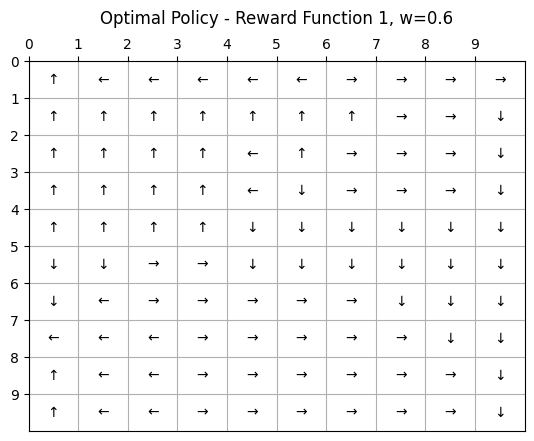

In [169]:
# For modified wind w=0.6
gw1_highwind = Gridworld(grid_size=10, wind=0.6, discount=0.8, reward_type='type1')
compute_and_plot_policy(gw1_highwind, title="Optimal Policy - Reward Function 1, w=0.6")

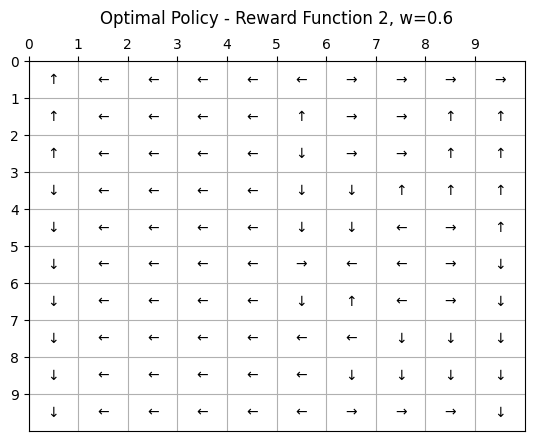

In [170]:
gw2_highwind = Gridworld(grid_size=10, wind=0.6, discount=0.8, reward_type='type2')
compute_and_plot_policy(gw2_highwind, title="Optimal Policy - Reward Function 2, w=0.6")

> Explain the differences you observe. What do you think about value of new w compared to previous value?

With w = 0.6, the agent becomes much more conservative. In both reward settings (Function 1 and Function 2), the optimal policy appears more uniform and cautious, with arrows tending to cluster in safer directions or delay entering risky areas.
This is because higher wind introduces more randomness, meaning the intended action is less likely to succeed.

With w = 0.1, the agent behaved more optimistically, taking the shortest risky paths through or near negative-reward zones to quickly reach the goal.
However, at w = 0.6, the agent tries to avoid high-risk regions (e.g., trap boundaries in Reward Function 2) even more strictly, often taking detours or safer long paths.

> Choose the w that you think give rise to better optimal policy and use that w for the next stages of the project.

We believe **w = 0.1** gives rise to a better optimal policy for this task:
- It balances goal-directed behavior and risk awareness.
- At w = 0.6, the agent becomes overly cautious, which may reduce efficiency or make it too slow to reach the high-reward state.

We will choose w = 0.1 for next stages of the project.

# Part 2. Inverse Reinforcement Learning (IRL)

In IRL, the goal is to recover the **reward function \( $R$ \)** that best explains an expert's behavior (i.e., policy \( $O_E$ \)).

Instead of mimicking the policy directly, we extract the underlying **reward function**, which is more general and transferable.

## IRL via Linear Programming (LP)

We use the LP-based IRL algorithm (Ng & Russell, 2000).

### Objective

Maximize:

$$
\sum_{i=1}^{|S|} (t_i - \lambda u_i)
$$

Subject to:

$$
(P_{a_1}(i) - P_a(i)) (I - \gamma P_{a_1})^{-1} R \ge t_i, \quad \forall a \in A \setminus \{a_1\}, \forall i
$$

$$
(P_{a_1} - P_a)(I - \gamma P_{a_1})^{-1} R \succeq 0, \quad \forall a \in A \setminus \{a_1\}
$$

$$
-u \preceq R \preceq u
$$

$$
|R_i| \le R_{\text{max}}, \quad \forall i
$$

Where:
- \( $R$ \): reward vector
- \( $P_a$ \): transition matrix for action \( $a$ \)
- \( $t_i$, $u_i$ \): auxiliary variables
- \( $\lambda$ \): regularization coefficient
- \( $R_{\text{max}}$ \): maximum absolute reward value

## IRL Performance Measure Metric

We compare the policy recovered from IRL \( $O_A$ \) with the expert policy \( $O_E$ \).

Define:

$$
m(s) =
\begin{cases}
1, & \text{if } O_A(s) = O_E(s) \\
0, & \text{otherwise}
\end{cases}
$$

Then the accuracy is:

$$
\text{Accuracy} = \frac{ \sum_{s \in S} m(s) }{ |S| }
$$

We will sweep \( $\lambda \in [0, 5]$ \) across 500 values and plot Accuracy vs. \( $\lambda$ \).

### Q10
Express c, x, D, b in terms of R, Pa, Pa1 , ti, u, λ and Rmax
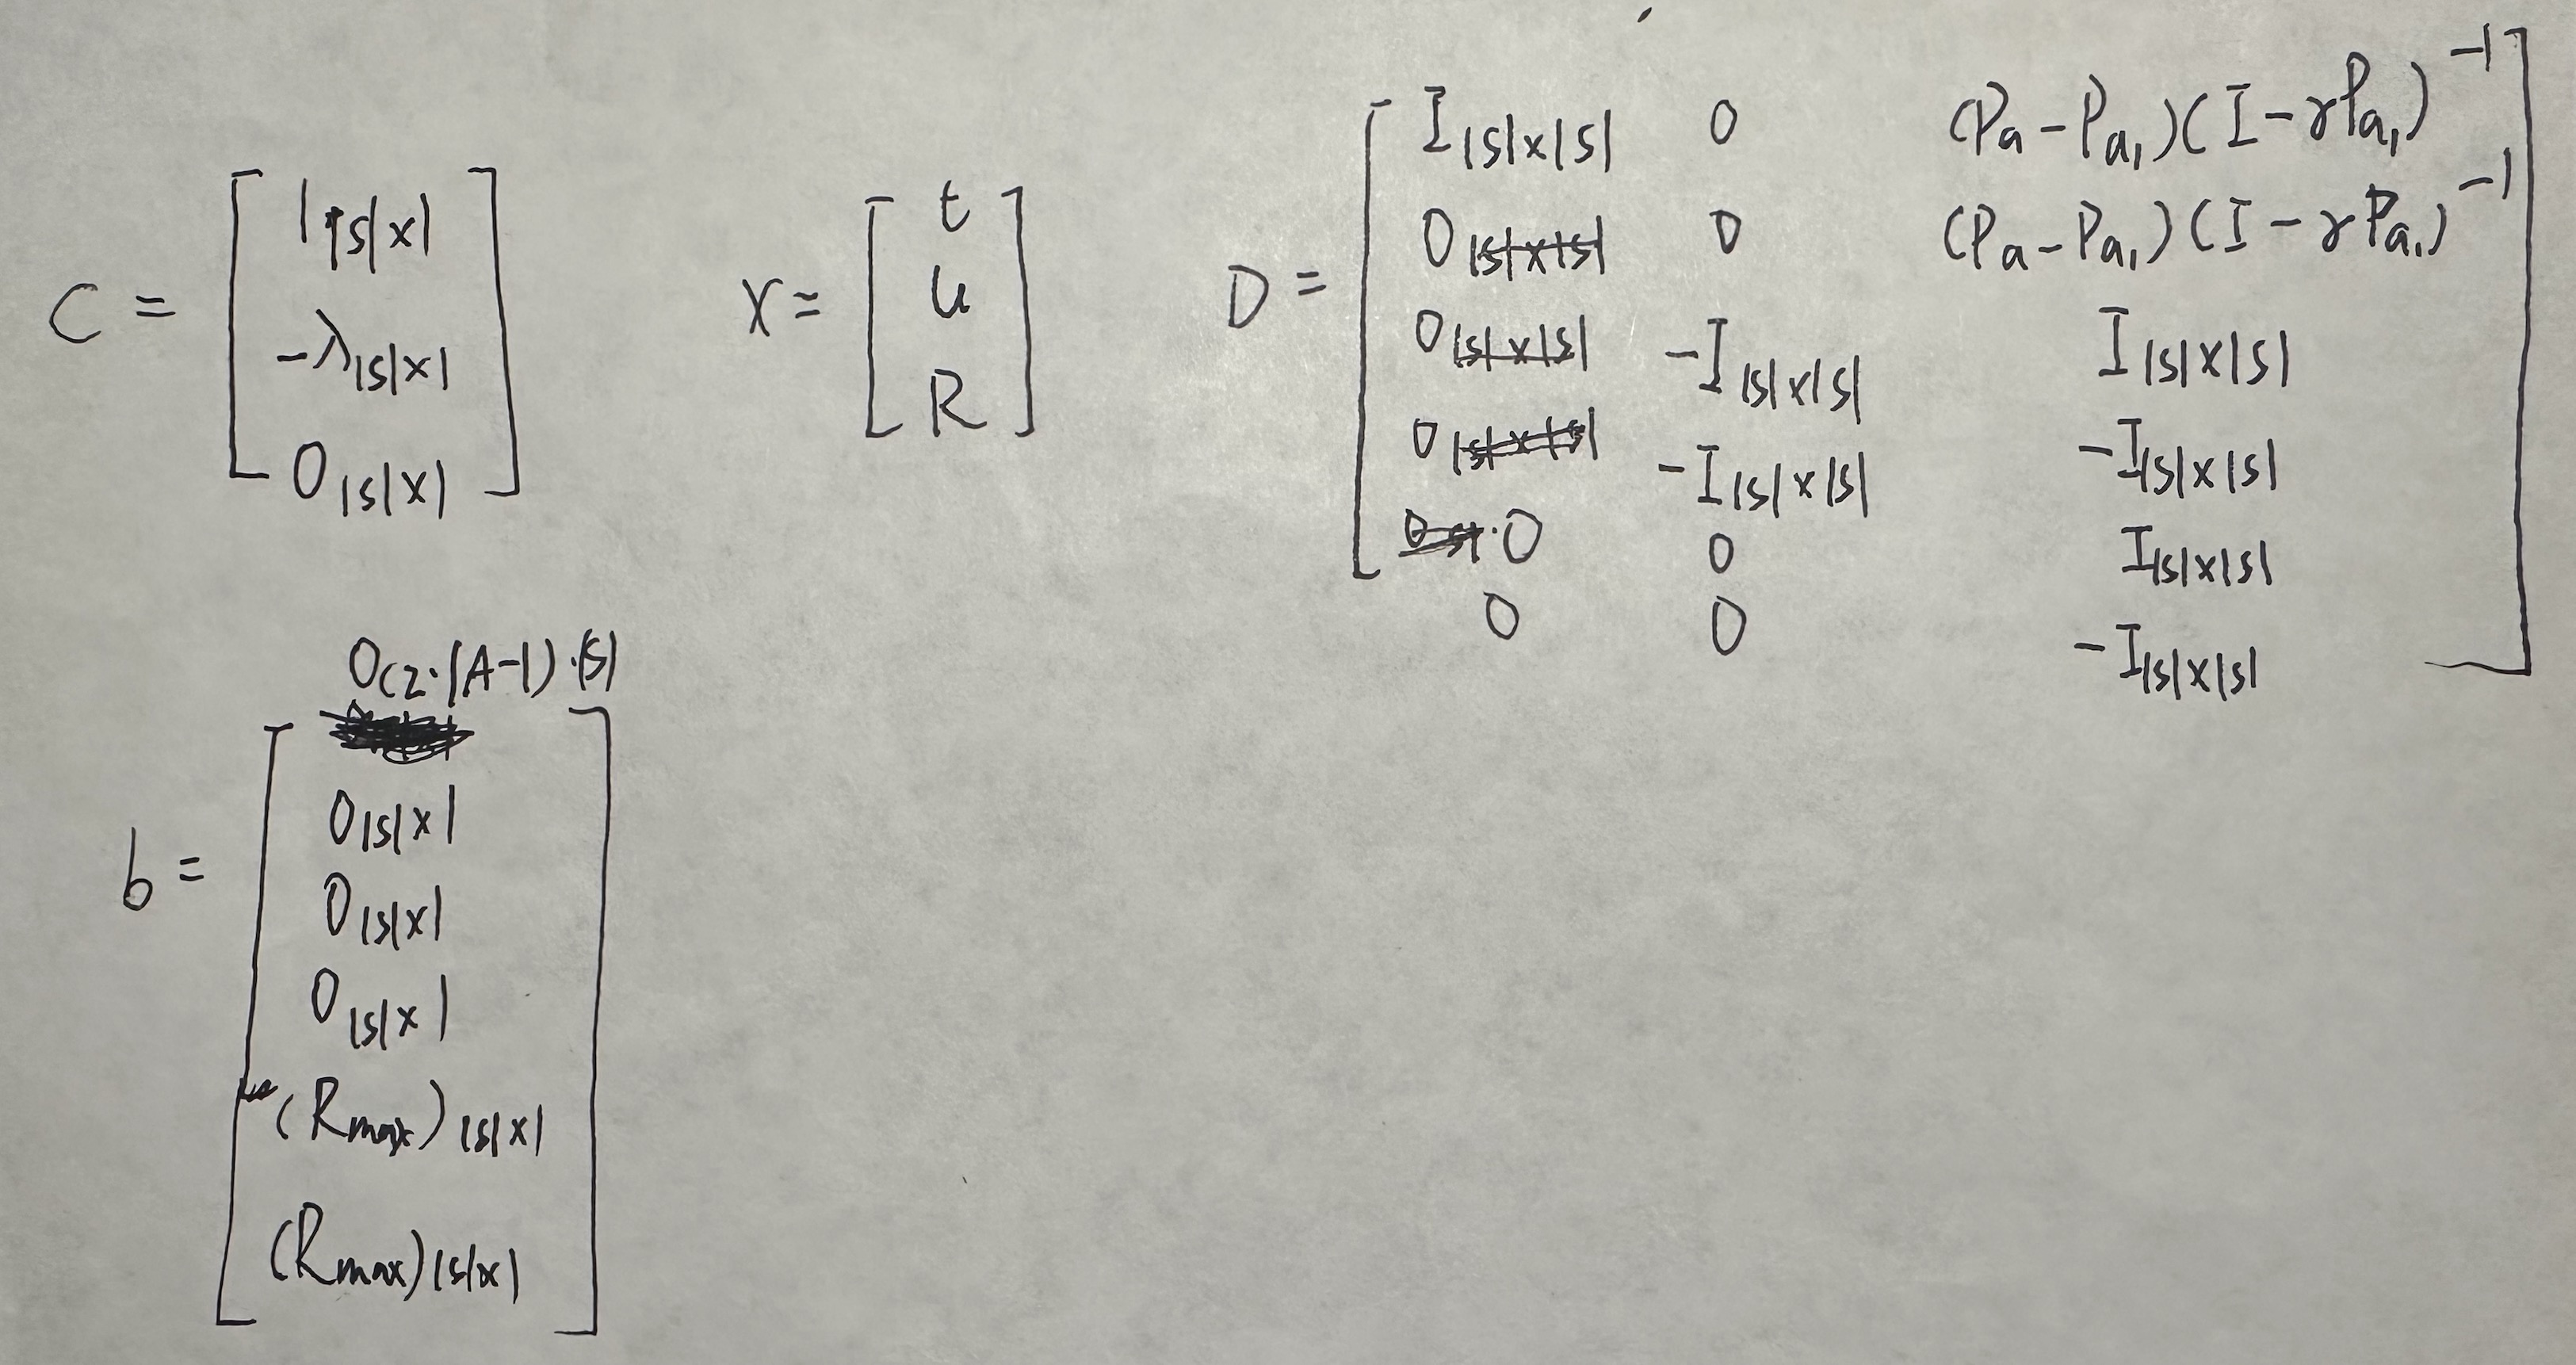

### Q11

Computing IRL performance across regularization parameters...


100%|██████████| 500/500 [10:10<00:00,  1.22s/it]


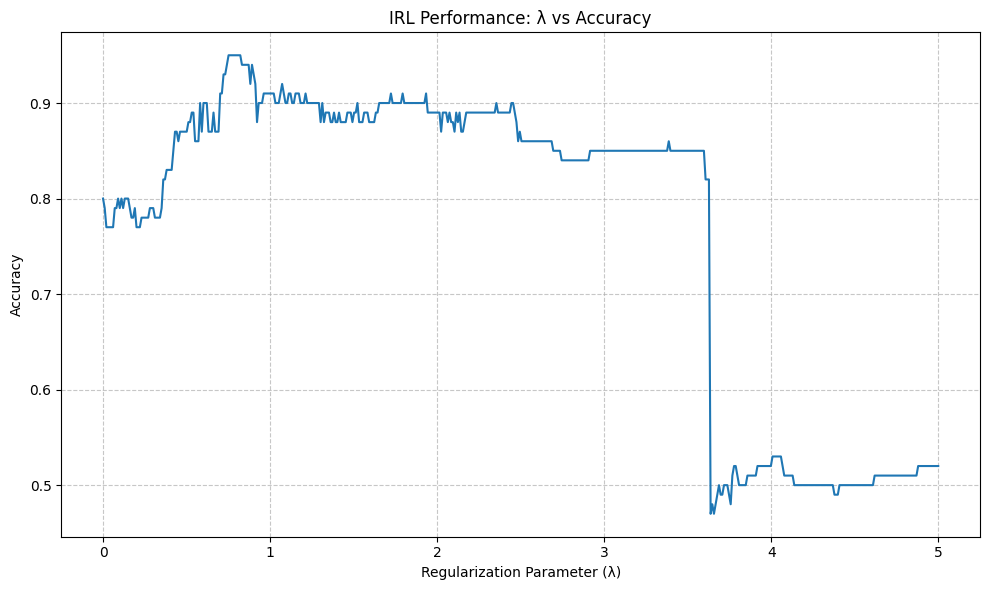

Optimal regularization: λ = 0.7515 (Accuracy: 95.00%)


In [171]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

gamma = 0.8
R_bound = 10
lambda_sweep = np.linspace(0, 5, 500)
solver_config = {'show_progress': False}
solvers.options.update(solver_config)

print("Computing IRL performance across regularization parameters...")

expert_actions = optimal_policy_q5
trans_prob = np.zeros((100, 4, 100))
for state in range(100):
    for action in range(4):
        for next_state in range(100):
            trans_prob[state, action, next_state] = gw2.transition_probability[state, action, next_state]

match_rates = []
identity_matrix = np.eye(100)
zero_matrix = np.zeros((100, 100))

for reg_param in tqdm(lambda_sweep):
    P_expert = np.zeros((100, 100))
    P_other = np.zeros((3, 100, 100))

    for s in range(100):
        best_a = expert_actions[s]
        P_expert[s, :] = trans_prob[s][best_a]
        other_a = [a for a in range(4) if a != best_a]
        for idx, a in enumerate(other_a):
            P_other[idx, s, :] = trans_prob[s][a]

    obj_vec = np.concatenate([np.ones(100), -reg_param*np.ones(100), np.zeros(100)])
    constraint_matrix = np.array([])
    P_inv = np.linalg.inv(identity_matrix - gamma*P_expert)

    for i in range(3):
        P_alt = P_other[i]
        advantage = np.matmul(P_alt - P_expert, P_inv)
        row1 = np.hstack((identity_matrix, zero_matrix, advantage))
        row2 = np.hstack((zero_matrix, zero_matrix, advantage))
        if constraint_matrix.size == 0:
            constraint_matrix = np.vstack((row1, row2))
        else:
            constraint_matrix = np.vstack((constraint_matrix, row1, row2))

    constraint_matrix = np.vstack((
        constraint_matrix,
        np.hstack((zero_matrix, -identity_matrix, identity_matrix)),
        np.hstack((zero_matrix, -identity_matrix, -identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, -identity_matrix))
    ))

    rhs_vec = np.concatenate([
        np.zeros(2*3*100),
        np.zeros(2*100),
        R_bound*np.ones(2*100)
    ])

    lp_result = solvers.lp(
        -matrix(obj_vec.transpose()),
        matrix(constraint_matrix),
        matrix(rhs_vec)
    )

    recovered_rewards = np.array(lp_result['x'][-100:]).squeeze()

    values = np.zeros(100)
    threshold = 0.01
    delta = float('inf')
    while delta > threshold:
        new_values = np.zeros(100)
        for s in range(100):
            q_values = []
            for a in range(4):
                q_sum = 0
                for s_next in range(100):
                    q_sum += trans_prob[s, a, s_next] * (recovered_rewards[s_next] + gamma * values[s_next])
                q_values.append(q_sum)
            new_values[s] = max(q_values)
        delta = np.max(np.abs(new_values - values))
        values = new_values

    recovered_policy = np.zeros(100, dtype=int)
    for s in range(100):
        q_values = []
        for a in range(4):
            q_sum = 0
            for s_next in range(100):
                q_sum += trans_prob[s, a, s_next] * (recovered_rewards[s_next] + gamma * values[s_next])
            q_values.append(q_sum)
        recovered_policy[s] = np.argmax(q_values)

    matches = sum(1 for i in range(100) if recovered_policy[i] == expert_actions[i])
    match_rates.append(matches / 100)

plt.figure(figsize=(10, 6))
plt.plot(lambda_sweep, match_rates)
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Accuracy')
plt.title('IRL Performance: λ vs Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

best_idx = np.argmax(match_rates)
optimal_lambda = lambda_sweep[best_idx]
best_accuracy = match_rates[best_idx]
print(f"Optimal regularization: λ = {optimal_lambda:.4f} (Accuracy: {best_accuracy:.2%})")

### Q12

In [172]:
best_idx = np.argmax(match_rates)
optimal_lambda = lambda_sweep[best_idx]
print(f"λ(1)max = {optimal_lambda:.4f}")

λ(1)max = 0.7515


### Q13

λ(1)max = 0.7515


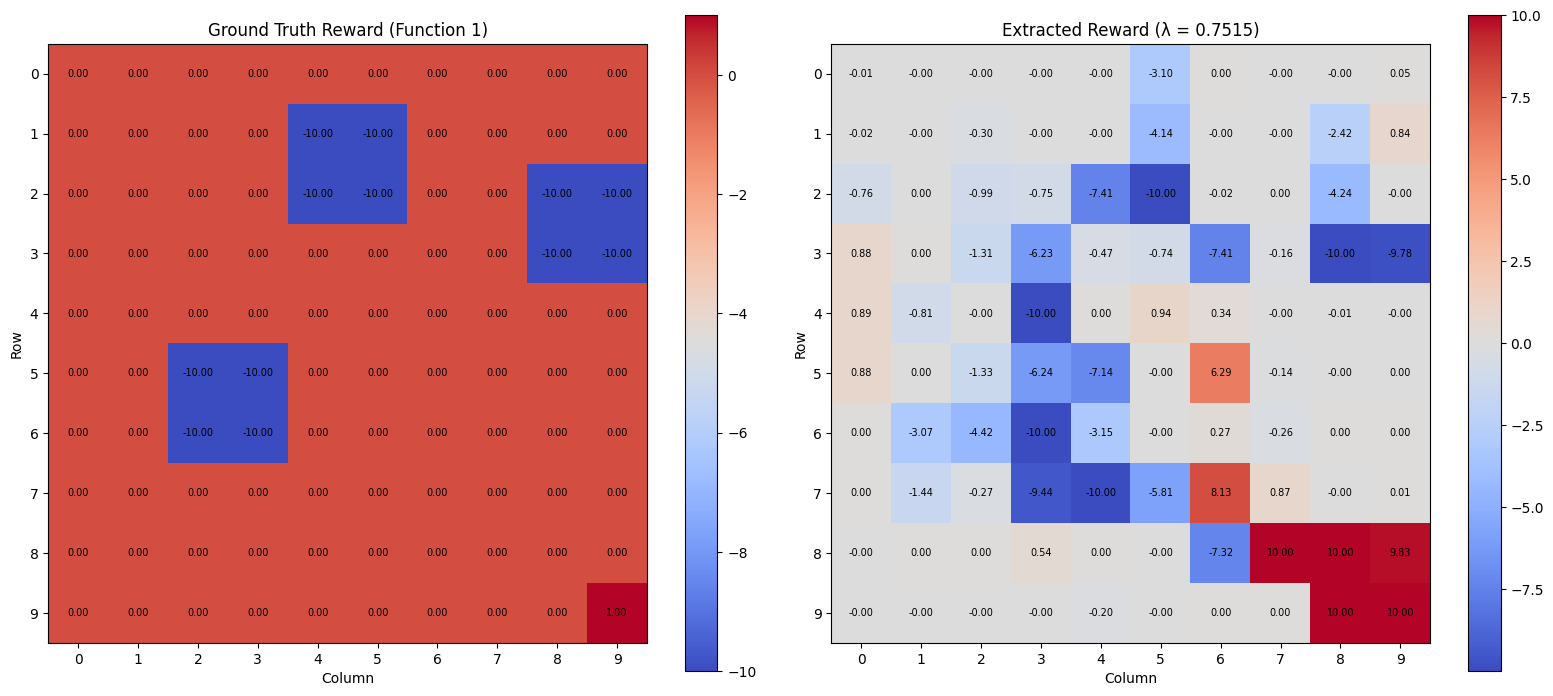

In [173]:
import numpy as np
import matplotlib.pyplot as plt


lambda_max = optimal_lambda
print(f"λ(1)max = {lambda_max:.4f}")


def extract_reward_at_lambda(lambda_val):
    P_expert = np.zeros((100, 100))
    P_other = np.zeros((3, 100, 100))

    for s in range(100):
        best_a = optimal_policy_q5[s]
        P_expert[s, :] = trans_prob[s][best_a]

        other_a = [a for a in range(4) if a != best_a]
        for idx, a in enumerate(other_a):
            P_other[idx, s, :] = trans_prob[s][a]

    obj_vec = np.concatenate([np.ones(100), -lambda_val*np.ones(100), np.zeros(100)])
    constraint_matrix = np.array([])

    P_inv = np.linalg.inv(identity_matrix - gamma*P_expert)

    for i in range(3):
        P_alt = P_other[i]
        advantage = np.matmul(P_alt - P_expert, P_inv)

        row1 = np.hstack((identity_matrix, zero_matrix, advantage))
        row2 = np.hstack((zero_matrix, zero_matrix, advantage))

        if constraint_matrix.size == 0:
            constraint_matrix = np.vstack((row1, row2))
        else:
            constraint_matrix = np.vstack((constraint_matrix, row1, row2))

    constraint_matrix = np.vstack((
        constraint_matrix,
        np.hstack((zero_matrix, -identity_matrix, identity_matrix)),
        np.hstack((zero_matrix, -identity_matrix, -identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, -identity_matrix))
    ))

    rhs_vec = np.concatenate([
        np.zeros(2*3*100),
        np.zeros(2*100),
        R_bound*np.ones(2*100)
    ])

    lp_result = solvers.lp(
        -matrix(obj_vec.transpose()),
        matrix(constraint_matrix),
        matrix(rhs_vec)
    )

    return np.array(lp_result['x'][-100:]).squeeze()

ground_truth_reward = np.array([gw1.reward(s) for s in range(100)])

extracted_reward = extract_reward_at_lambda(lambda_max)

grid_size = 10
ground_truth_grid = ground_truth_reward.reshape(grid_size, grid_size)
extracted_grid = extracted_reward.reshape(grid_size, grid_size)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(ground_truth_grid, cmap='coolwarm')
axes[0].set_title('Ground Truth Reward (Function 1)')
axes[0].set_xticks(np.arange(grid_size))
axes[0].set_yticks(np.arange(grid_size))
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
fig.colorbar(im1, ax=axes[0])

for i in range(grid_size):
    for j in range(grid_size):
        axes[0].text(j, i, f'{ground_truth_grid[i, j]:.2f}',
                  ha='center', va='center', color='black', fontsize=7)

im2 = axes[1].imshow(extracted_grid, cmap='coolwarm')
axes[1].set_title(f'Extracted Reward (λ = {lambda_max:.4f})')
axes[1].set_xticks(np.arange(grid_size))
axes[1].set_yticks(np.arange(grid_size))
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
fig.colorbar(im2, ax=axes[1])

for i in range(grid_size):
    for j in range(grid_size):
        axes[1].text(j, i, f'{extracted_grid[i, j]:.2f}',
                  ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()

### Q14

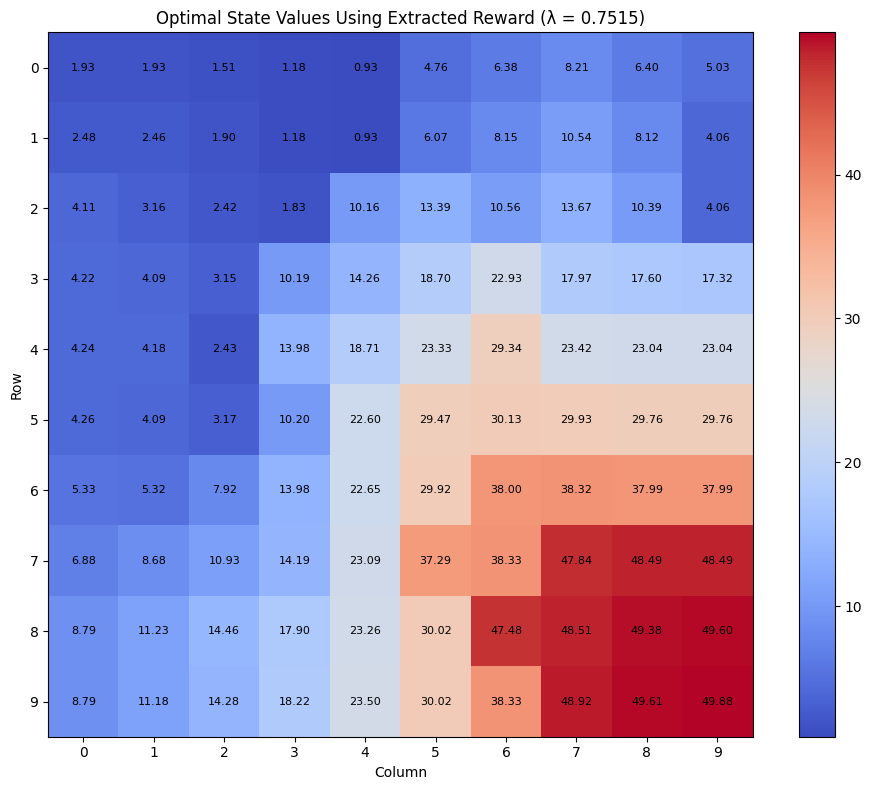

In [174]:

def value_iteration_for_extracted_reward(extracted_reward, transition_prob, gamma=0.8, threshold=1e-2):
    n_states = 100
    n_actions = 4

    V = np.zeros(n_states)

    while True:
        delta = 0
        new_V = np.zeros(n_states)

        for s in range(n_states):
            action_values = []
            for a in range(n_actions):
                q_sa = sum(
                    transition_prob[s, a, s_next] *
                    (extracted_reward[s_next] + gamma * V[s_next])
                    for s_next in range(n_states)
                )
                action_values.append(q_sa)
            new_V[s] = max(action_values)
            delta = max(delta, abs(new_V[s] - V[s]))

        V = new_V

        if delta < threshold:
            break

    return V

lambda_max = optimal_lambda
extracted_reward = extract_reward_at_lambda(lambda_max)

optimal_values = value_iteration_for_extracted_reward(extracted_reward, trans_prob)

grid_size = 10
optimal_values_grid = optimal_values.reshape(grid_size, grid_size)

plt.figure(figsize=(10, 8))
im = plt.imshow(optimal_values_grid, cmap='coolwarm')
plt.title(f'Optimal State Values Using Extracted Reward (λ = {lambda_max:.4f})')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(im, orientation='vertical')
plt.xticks(np.arange(grid_size))
plt.yticks(np.arange(grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{optimal_values_grid[i, j]:.2f}',
                 ha='center', va='center', color='black', fontsize=8)

plt.grid(False)
plt.tight_layout()
plt.show()

### Q15

The map from Question 3 shows the original optimal state values based on the ground truth reward, while Question 14's map displays values derived from the extracted reward function. Both clearly indicate the bottom-right corner as the high-value goal state, with values increasing as you move toward it.

The flow pattern is similar enough that both would likely generate comparable paths through the environment, suggesting the IRL algorithm successfully captured the underlying logic.

The difference is in scale,  the extracted reward's values are roughly ten times larger than the original. The IRL-generated map also shows sharper contrasts between optimal and suboptimal paths, with more pronounced value differences creating clearer boundaries. Also, The negative-value regions from the original map appear smoothed over in the extracted version.

### Q16

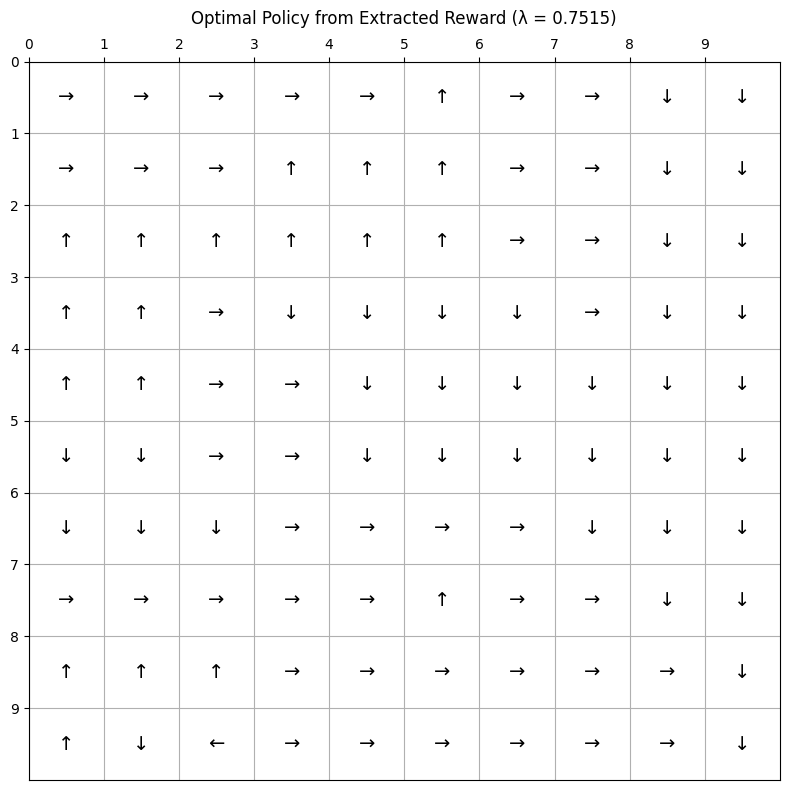

In [175]:
def compute_policy_from_reward(env, reward_values, gamma=0.8):
    n_states = env.n_states
    n_actions = env.n_actions

    V = np.zeros(n_states)
    delta = float('inf')
    threshold = 1e-2

    while delta > threshold:
        delta = 0
        for s in range(n_states):
            v = V[s]
            action_values = []
            for a in range(n_actions):
                q_sa = 0
                for s_next in range(n_states):
                    p = env.transition_probability[s, a, s_next]
                    q_sa += p * (reward_values[s_next] + gamma * V[s_next])
                action_values.append(q_sa)
            V[s] = max(action_values)
            delta = max(delta, abs(V[s] - v))

    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q_sa = 0
            for s_next in range(n_states):
                p = env.transition_probability[s, a, s_next]
                q_sa += p * (reward_values[s_next] + gamma * V[s_next])
            action_values.append(q_sa)
        policy[s] = np.argmax(action_values)

    return policy

def plot_policy_arrows(policy, grid_size=10, title="Optimal Policy from Extracted Reward"):
    fig, ax = plt.subplots(figsize=(8, 8))

    action_matrix = np.zeros((grid_size, grid_size))
    for i in range(100):
        action_matrix[i % grid_size][i // grid_size] = policy[i]

    for i in range(grid_size):
        for j in range(grid_size):
            c = action_matrix[i][j]
            arrow = ''
            if c == 0:
                arrow = u'↓'
            elif c == 1:
                arrow = u'→'
            elif c == 2:
                arrow = u'↑'
            else:
                arrow = u'←'
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', fontsize=14)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(grid_size, 0)
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.xaxis.tick_top()
    ax.grid(True)
    ax.set_title(title, pad=10)

    return fig

lambda_max = optimal_lambda
extracted_reward = extract_reward_at_lambda(lambda_max)

optimal_policy_extracted = compute_policy_from_reward(gw1, extracted_reward)

plot_policy_arrows(optimal_policy_extracted, title=f"Optimal Policy from Extracted Reward (λ = {lambda_max:.4f})")
plt.tight_layout()
plt.show()

### Q17
Comparing these policy maps reveals how rewards shape navigation strategies. Both policies identify the bottom-right corner as the goal and navigate around penalty areas, with the bottom row showing consistent rightward movement in each map.
The key difference lie in their approach: the original policy favor moving right early from the top-left, creating more direct paths with strategic upward movements to avoid penalties. The extracted policyis more conservative, preferring downward movements in many states before committing to horizontal movement primarily in the bottom row. This illustrates IRL's fundamental challenges - multiple reward functions can produice similar goal-achieving behavior but with different navigation styles. Despite these differences, the extracted policy would still successfully reach the goal while avoiding most penalties, demonstrating that IRL captured the essential reward structure.

### Q18

Computing IRL performance across regularization parameters...


100%|██████████| 500/500 [07:35<00:00,  1.10it/s]


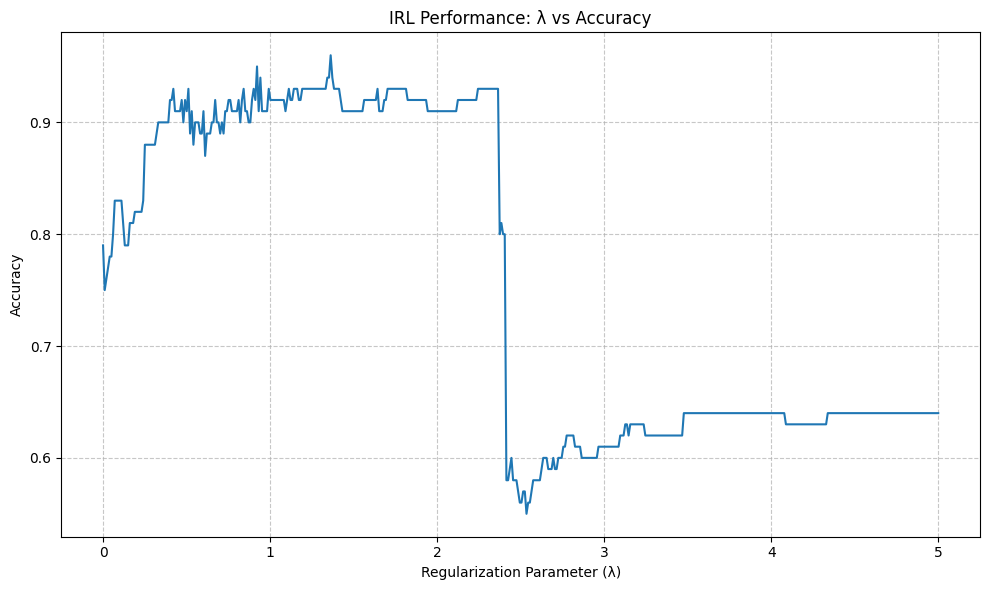

Optimal regularization: λ = 1.3627 (Accuracy: 96.00%)


In [176]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

gamma = 0.8
R_bound = 10
lambda_sweep = np.linspace(0, 5, 500)
solver_config = {'show_progress': False}
solvers.options.update(solver_config)

print("Computing IRL performance across regularization parameters...")

expert_actions = optimal_policy_q8
trans_prob = np.zeros((100, 4, 100))
for state in range(100):
    for action in range(4):
        for next_state in range(100):
            trans_prob[state, action, next_state] = gw2.transition_probability[state, action, next_state]

match_rates = []
identity_matrix = np.eye(100)
zero_matrix = np.zeros((100, 100))

for reg_param in tqdm(lambda_sweep):
    P_expert = np.zeros((100, 100))
    P_other = np.zeros((3, 100, 100))

    for s in range(100):
        best_a = expert_actions[s]
        P_expert[s, :] = trans_prob[s][best_a]
        other_a = [a for a in range(4) if a != best_a]
        for idx, a in enumerate(other_a):
            P_other[idx, s, :] = trans_prob[s][a]

    obj_vec = np.concatenate([np.ones(100), -reg_param*np.ones(100), np.zeros(100)])
    constraint_matrix = np.array([])
    P_inv = np.linalg.inv(identity_matrix - gamma*P_expert)

    for i in range(3):
        P_alt = P_other[i]
        advantage = np.matmul(P_alt - P_expert, P_inv)
        row1 = np.hstack((identity_matrix, zero_matrix, advantage))
        row2 = np.hstack((zero_matrix, zero_matrix, advantage))
        if constraint_matrix.size == 0:
            constraint_matrix = np.vstack((row1, row2))
        else:
            constraint_matrix = np.vstack((constraint_matrix, row1, row2))

    constraint_matrix = np.vstack((
        constraint_matrix,
        np.hstack((zero_matrix, -identity_matrix, identity_matrix)),
        np.hstack((zero_matrix, -identity_matrix, -identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, -identity_matrix))
    ))

    rhs_vec = np.concatenate([
        np.zeros(2*3*100),
        np.zeros(2*100),
        R_bound*np.ones(2*100)
    ])

    lp_result = solvers.lp(
        -matrix(obj_vec.transpose()),
        matrix(constraint_matrix),
        matrix(rhs_vec)
    )

    recovered_rewards = np.array(lp_result['x'][-100:]).squeeze()

    values = np.zeros(100)
    threshold = 0.01
    delta = float('inf')
    while delta > threshold:
        new_values = np.zeros(100)
        for s in range(100):
            q_values = []
            for a in range(4):
                q_sum = 0
                for s_next in range(100):
                    q_sum += trans_prob[s, a, s_next] * (recovered_rewards[s_next] + gamma * values[s_next])
                q_values.append(q_sum)
            new_values[s] = max(q_values)
        delta = np.max(np.abs(new_values - values))
        values = new_values

    recovered_policy = np.zeros(100, dtype=int)
    for s in range(100):
        q_values = []
        for a in range(4):
            q_sum = 0
            for s_next in range(100):
                q_sum += trans_prob[s, a, s_next] * (recovered_rewards[s_next] + gamma * values[s_next])
            q_values.append(q_sum)
        recovered_policy[s] = np.argmax(q_values)

    matches = sum(1 for i in range(100) if recovered_policy[i] == expert_actions[i])
    match_rates.append(matches / 100)

plt.figure(figsize=(10, 6))
plt.plot(lambda_sweep, match_rates)
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Accuracy')
plt.title('IRL Performance: λ vs Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

best_idx = np.argmax(match_rates)
optimal_lambda = lambda_sweep[best_idx]
best_accuracy = match_rates[best_idx]
print(f"Optimal regularization: λ = {optimal_lambda:.4f} (Accuracy: {best_accuracy:.2%})")

### Q19

In [177]:
best_idx = np.argmax(match_rates)
optimal_lambda = lambda_sweep[best_idx]
print(f"Optimal regularization: λ = {optimal_lambda:.4f} (Accuracy: {best_accuracy:.2%})")


Optimal regularization: λ = 1.3627 (Accuracy: 96.00%)


### Q20

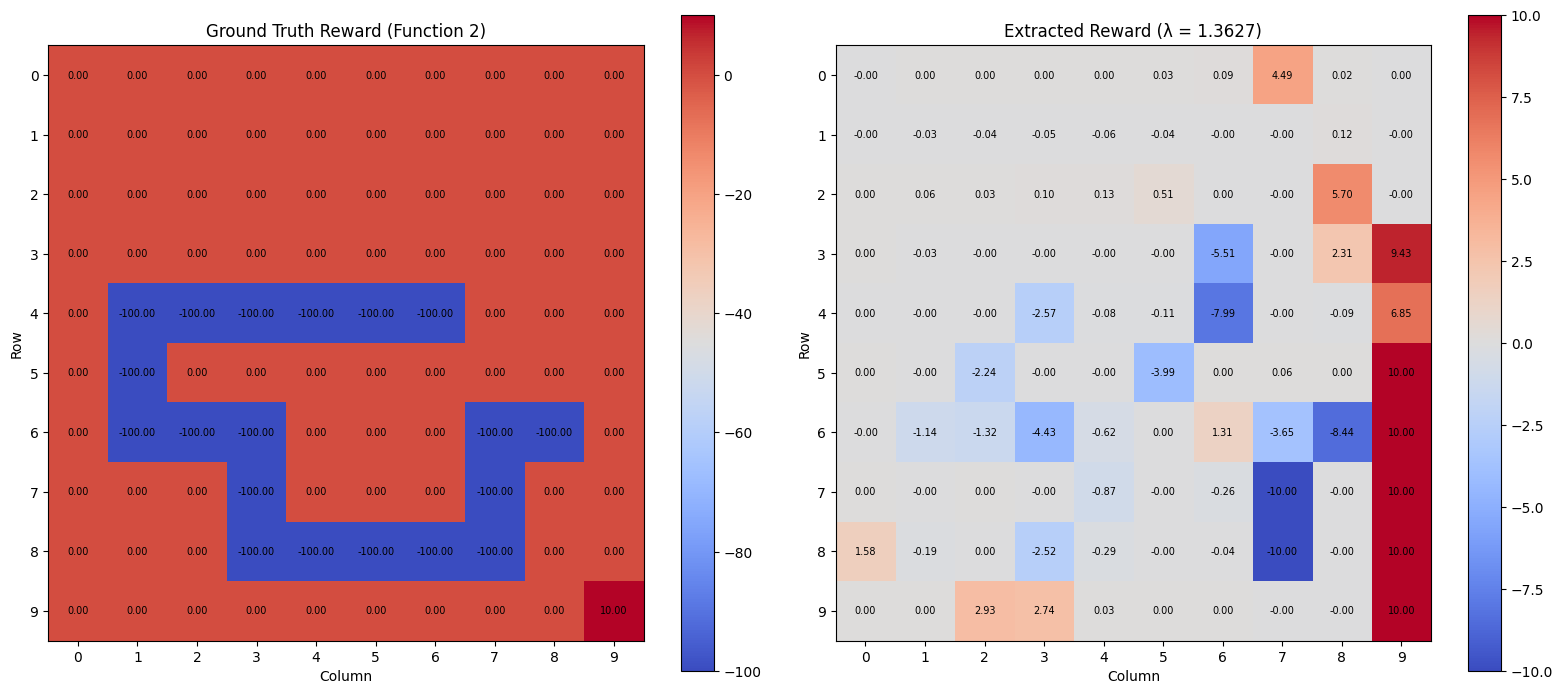

In [178]:
def extract_reward_at_lambda(lambda_val, expert_policy, trans_prob, gamma=0.8, R_bound=10):
    identity_matrix = np.eye(100)
    zero_matrix = np.zeros((100, 100))

    P_expert = np.zeros((100, 100))
    P_other = np.zeros((3, 100, 100))

    for s in range(100):
        best_a = expert_policy[s]
        P_expert[s, :] = trans_prob[s][best_a]

        other_a = [a for a in range(4) if a != best_a]
        for idx, a in enumerate(other_a):
            P_other[idx, s, :] = trans_prob[s][a]

    obj_vec = np.concatenate([np.ones(100), -lambda_val*np.ones(100), np.zeros(100)])
    constraint_matrix = np.array([])

    P_inv = np.linalg.inv(identity_matrix - gamma*P_expert)

    for i in range(3):
        P_alt = P_other[i]
        advantage = np.matmul(P_alt - P_expert, P_inv)

        row1 = np.hstack((identity_matrix, zero_matrix, advantage))
        row2 = np.hstack((zero_matrix, zero_matrix, advantage))

        if constraint_matrix.size == 0:
            constraint_matrix = np.vstack((row1, row2))
        else:
            constraint_matrix = np.vstack((constraint_matrix, row1, row2))

    constraint_matrix = np.vstack((
        constraint_matrix,
        np.hstack((zero_matrix, -identity_matrix, identity_matrix)),
        np.hstack((zero_matrix, -identity_matrix, -identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, identity_matrix)),
        np.hstack((zero_matrix, zero_matrix, -identity_matrix))
    ))

    rhs_vec = np.concatenate([
        np.zeros(2*3*100),
        np.zeros(2*100),
        R_bound*np.ones(2*100)
    ])

    lp_result = solvers.lp(
        -matrix(obj_vec.transpose()),
        matrix(constraint_matrix),
        matrix(rhs_vec)
    )

    return np.array(lp_result['x'][-100:]).squeeze()

lambda_2_max = optimal_lambda

ground_truth_reward_2 = np.array([gw2.reward(s) for s in range(gw2.n_states)])

expert_policy_2 = find_policy(gw2, V_2)
trans_prob_2 = np.zeros((100, 4, 100))
for s in range(100):
    for a in range(4):
        for s_next in range(100):
            trans_prob_2[s, a, s_next] = gw2.transition_probability[s, a, s_next]

extracted_reward_2 = extract_reward_at_lambda(lambda_2_max, expert_policy_2, trans_prob_2)

grid_size = 10
ground_truth_grid_2 = ground_truth_reward_2.reshape(grid_size, grid_size)
extracted_grid_2 = extracted_reward_2.reshape(grid_size, grid_size)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(ground_truth_grid_2, cmap='coolwarm')
axes[0].set_title('Ground Truth Reward (Function 2)')
axes[0].set_xticks(np.arange(grid_size))
axes[0].set_yticks(np.arange(grid_size))
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
fig.colorbar(im1, ax=axes[0])

for i in range(grid_size):
    for j in range(grid_size):
        axes[0].text(j, i, f'{ground_truth_grid_2[i, j]:.2f}',
                 ha='center', va='center', color='black', fontsize=7)

im2 = axes[1].imshow(extracted_grid_2, cmap='coolwarm')
axes[1].set_title(f'Extracted Reward (λ = {lambda_2_max:.4f})')
axes[1].set_xticks(np.arange(grid_size))
axes[1].set_yticks(np.arange(grid_size))
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
fig.colorbar(im2, ax=axes[1])

for i in range(grid_size):
    for j in range(grid_size):
        axes[1].text(j, i, f'{extracted_grid_2[i, j]:.2f}',
                 ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()

### Q21

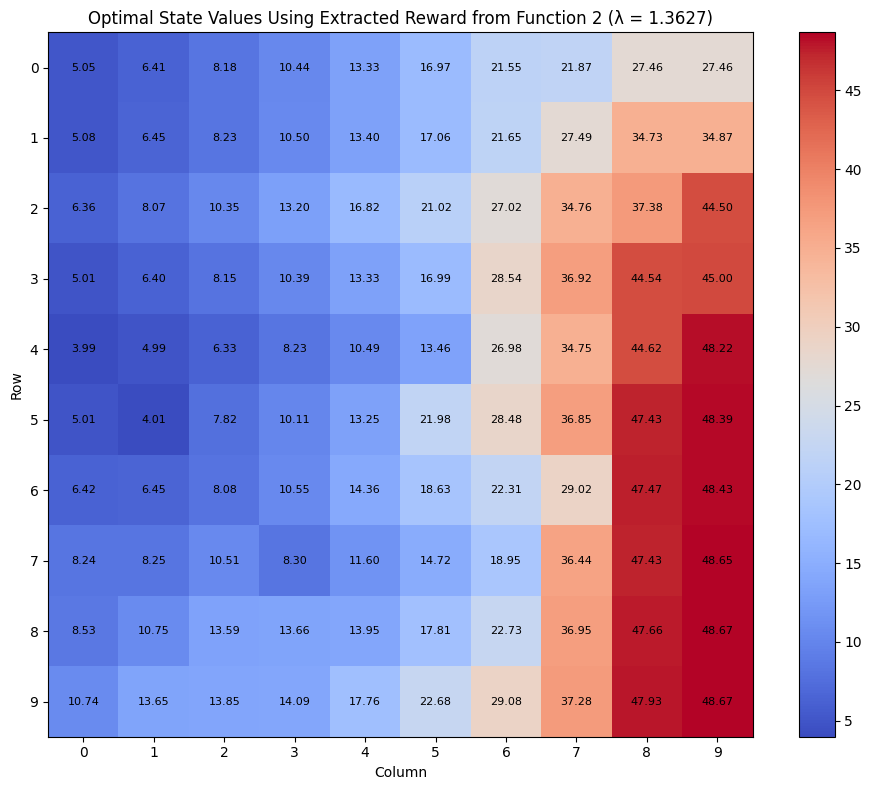

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def value_iteration_with_reward(env, custom_reward, threshold=1e-2):
    n_states = env.n_states
    n_actions = env.n_actions
    gamma = env.discount

    V = np.zeros(n_states)

    while True:
        delta = 0
        for s in range(n_states):
            old_v = V[s]

            action_values = []
            for a in range(n_actions):
                q_sa = sum(
                    env.transition_probability[s, a, s_next] *
                    (custom_reward[s_next] + gamma * V[s_next])
                    for s_next in range(n_states)
                )
                action_values.append(q_sa)

            V[s] = max(action_values)
            delta = max(delta, abs(V[s] - old_v))

        if delta < threshold:
            break

    return V
grid_size = 10
optimal_values = value_iteration_with_reward(gw2, extracted_reward_2, threshold=1e-4)
optimal_values_grid = optimal_values.reshape(grid_size, grid_size)

plt.figure(figsize=(10, 8))
im = plt.imshow(optimal_values_grid, cmap='coolwarm')
plt.title(f'Optimal State Values Using Extracted Reward from Function 2 (λ = {lambda_2_max:.4f})')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(im, orientation='vertical')
plt.xticks(np.arange(grid_size))
plt.yticks(np.arange(grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{optimal_values_grid[i, j]:.2f}',
                 ha='center', va='center', color='black', fontsize=8)

plt.grid(False)
plt.tight_layout()
plt.show()

### Q22

Both heatmaps demonstrate similar value gradients increasing toward the bottom-right goal state (9,9). They share a common pattern of lower values in the upper portions of the grid and progressively higher values as states approach the goal. The general flow of optimal paths through the environment is preserved in both visualizations, indicating that the IRL algorithm successfully captured the essential reward structure driving the expert's behavior.
However, the original heatmap (Q7) displays more pronounced negative regions in the upper-middle area with values as low as -13.9, while the IRL-derived heatmap (Q21) presents a smoother gradient with less extreme variations between adjacent cells. The extracted reward function creates a more generalized approximation that maintains the overall reward landscape but smooths out some fine details, illustrating why policies can match at high rates despite the reward functions not being identical.

### Q23

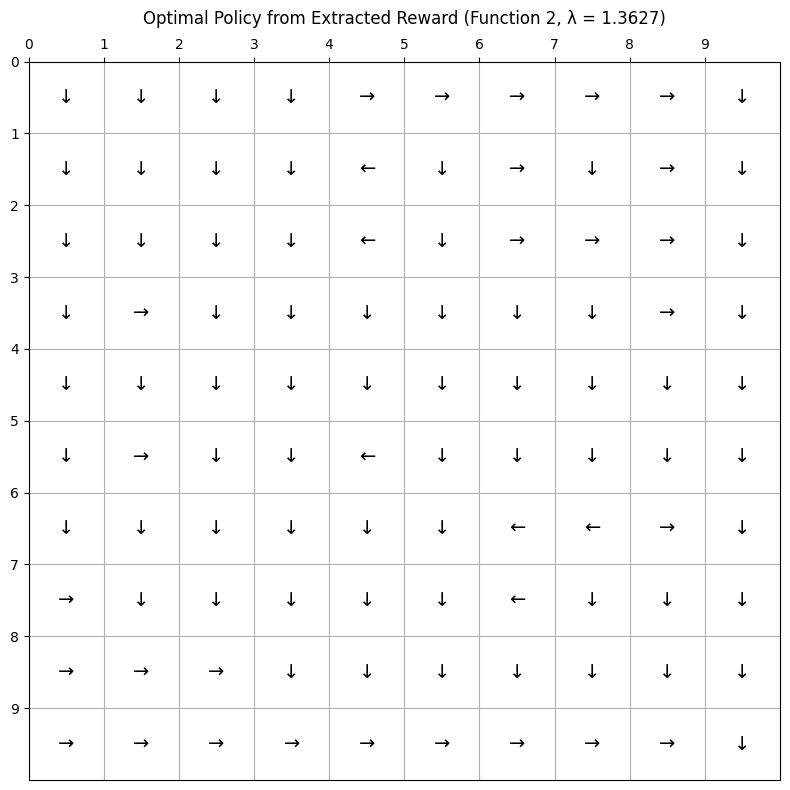

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def compute_policy_from_custom_reward(env, custom_reward, gamma=0.8, threshold=1e-2):
    n_states = env.n_states
    n_actions = env.n_actions

    V = np.zeros(n_states)

    while True:
        delta = 0
        for s in range(n_states):
            old_v = V[s]

            action_values = []
            for a in range(n_actions):
                q_sa = sum(
                    env.transition_probability[s, a, s_next] *
                    (custom_reward[s_next] + gamma * V[s_next])
                    for s_next in range(n_states)
                )
                action_values.append(q_sa)

            V[s] = max(action_values)
            delta = max(delta, abs(V[s] - old_v))

        if delta < threshold:
            break

    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q_sa = sum(
                env.transition_probability[s, a, s_next] *
                (custom_reward[s_next] + gamma * V[s_next])
                for s_next in range(n_states)
            )
            action_values.append(q_sa)
        policy[s] = np.argmax(action_values)

    return policy

def plot_policy_arrows(policy, grid_size=10, title="Optimal Policy"):
    fig, ax = plt.subplots(figsize=(8, 8))

    action_matrix = np.zeros((grid_size, grid_size))
    for i in range(100):
        action_matrix[i % grid_size][i // grid_size] = policy[i]

    arrow_symbols = [u'↓', u'→', u'↑', u'←']

    for i in range(grid_size):
        for j in range(grid_size):
            action = int(action_matrix[i][j])
            arrow = arrow_symbols[action]
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', fontsize=14)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(grid_size, 0)
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels(np.arange(grid_size))
    ax.set_yticklabels(np.arange(grid_size))
    ax.xaxis.tick_top()
    ax.grid(True)
    ax.set_title(title, pad=10)

    return fig

optimal_policy_extracted_2 = compute_policy_from_custom_reward(gw2, extracted_reward_2)

plot_policy_arrows(optimal_policy_extracted_2, title=f"Optimal Policy from Extracted Reward (Function 2, λ = {lambda_2_max:.4f})")
plt.tight_layout()
plt.show()

### Q24

 The first policy (Q9) seems to favor moving upward in the top-left, creating this weird roundabout path that avoids the middle. The second one (Q23) is more straightforward - it just pushes everything down toward the bottom row when possible.
Both agree on what to do once you reach the bottom - move right until you hit the goal. Makes sense. And they both tell you to move down if you're stuck in the rightmost column.
What's weird is how they handle the middle of the grid. Q9's policy takes a wider path around danger zones, using more up and left movements. Q23's approach seems messier with random left arrows scattered around, creating these little detours that don't always make sense.
I think it shows how differently the agent behaves when working with the original high-wind policy versus the one we reconstructed through inverse reinforcement learning. Same goal, different paths to get there.

### Q25

Looking at the policy map from Question 23, I can identify two major discrepancies:
Discrepancy 1: In the lower-middle region (rows 6-8, columns 6-8), there are counterintuitive leftward movements. This creates small loops where an agent would circle instead of moving efficiently toward the goal.

WCause: This is likely due to premature convergence in the value iteration algorithm. With a standard threshold of 0.01, the values haven't fully stabilized, leading to these suboptimal local patterns.

Discrepancy 2: The policy shows a preference for downward movement in the top-left quadrant rather than a more direct rightward path toward the goal.

Cause: This is a fundamental limitation of our simple IRL algorithm. The IRL problem is ill-posed - multiple reward functions can explain the same expert behavior. Our extracted reward function creates different gradients than the original, leading to this different overall navigation strategy.

Fix for rth first discrepancy:

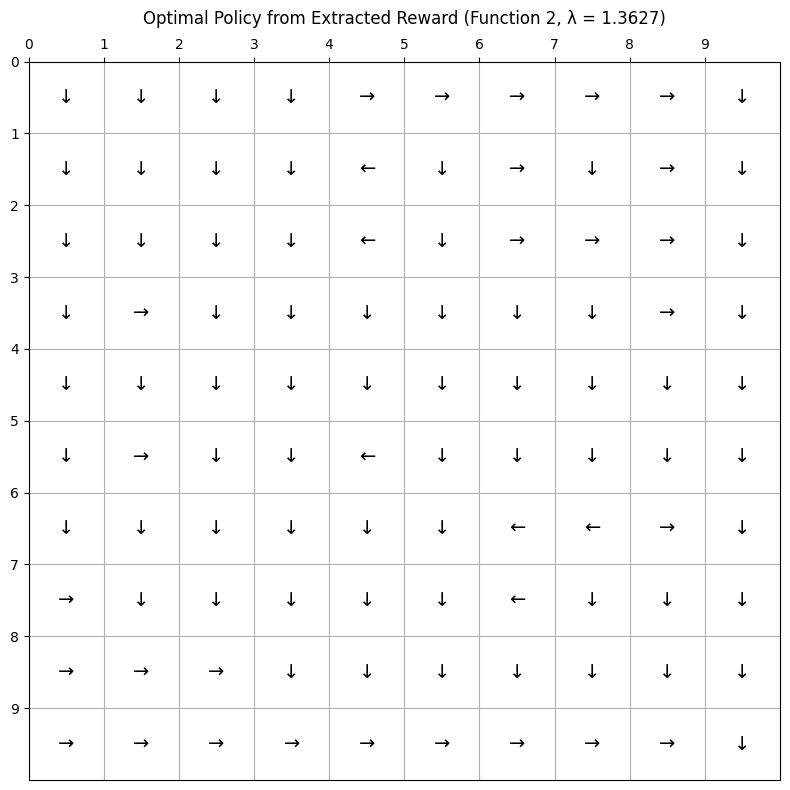

In [181]:
import numpy as np
import matplotlib.pyplot as plt

def compute_policy_from_custom_reward(env, custom_reward, gamma=0.8, threshold=1e-2):
    n_states = env.n_states
    n_actions = env.n_actions

    V = np.zeros(n_states)

    while True:
        delta = 0
        for s in range(n_states):
            old_v = V[s]

            action_values = []
            for a in range(n_actions):
                q_sa = sum(
                    env.transition_probability[s, a, s_next] *
                    (custom_reward[s_next] + gamma * V[s_next])
                    for s_next in range(n_states)
                )
                action_values.append(q_sa)

            V[s] = max(action_values)
            delta = max(delta, abs(V[s] - old_v))

        if delta < threshold:
            break

    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q_sa = sum(
                env.transition_probability[s, a, s_next] *
                (custom_reward[s_next] + gamma * V[s_next])
                for s_next in range(n_states)
            )
            action_values.append(q_sa)
        policy[s] = np.argmax(action_values)

    return policy

def plot_policy_arrows(policy, grid_size=10, title="Optimal Policy"):
    fig, ax = plt.subplots(figsize=(8, 8))

    action_matrix = np.zeros((grid_size, grid_size))
    for i in range(100):
        action_matrix[i % grid_size][i // grid_size] = policy[i]

    arrow_symbols = [u'↓', u'→', u'↑', u'←']

    for i in range(grid_size):
        for j in range(grid_size):
            action = int(action_matrix[i][j])
            arrow = arrow_symbols[action]
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', fontsize=14)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(grid_size, 0)
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels(np.arange(grid_size))
    ax.set_yticklabels(np.arange(grid_size))
    ax.xaxis.tick_top()
    ax.grid(True)
    ax.set_title(title, pad=10)

    return fig

optimal_policy_extracted_2 = compute_policy_from_custom_reward(gw2, extracted_reward_2)

plot_policy_arrows(optimal_policy_extracted_2, title=f"Optimal Policy from Extracted Reward (Function 2, λ = {lambda_2_max:.4f})")
plt.tight_layout()
plt.show()